<a href="https://colab.research.google.com/github/ElisaCastelli/CPAC_CollectiveDynamicPortrait/blob/main/CPACprovaFaceDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style transfer

In [1]:
# explain various inputs
import numpy as np
import PIL

import keras
import tensorflow as tf
import tensorflow_hub as hub

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
# explain what does this function do
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [3]:
# Converts tensor into image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

### organize style files

In [29]:
image_format = '.png'
image_folder = 'style_pics/'
# here I should receive parameters from spotify
acousticness = 0
valence = 0

#style_filename =  image_folder + str(acousticness) + str(valence) + image_format
style_filename = 'bosch_garden.jpg'
content_filename = 'dummy2.jpg'

In [30]:
content_image = load_img(image_folder + content_filename)
style_image = load_img(image_folder + style_filename)

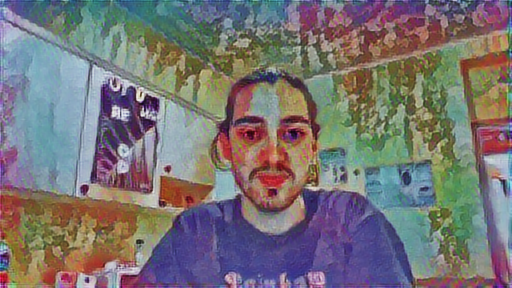

In [31]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
output = tensor_to_image(stylized_image)

output.save(image_folder + 'stylized' +style_filename) 

tensor_to_image(stylized_image)

# manual version

In [32]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

#from numba import jit, cuda       

In [33]:
# Converts tensor into image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [34]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [35]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

        plt.imshow(image)
    if title:
        plt.title(title)

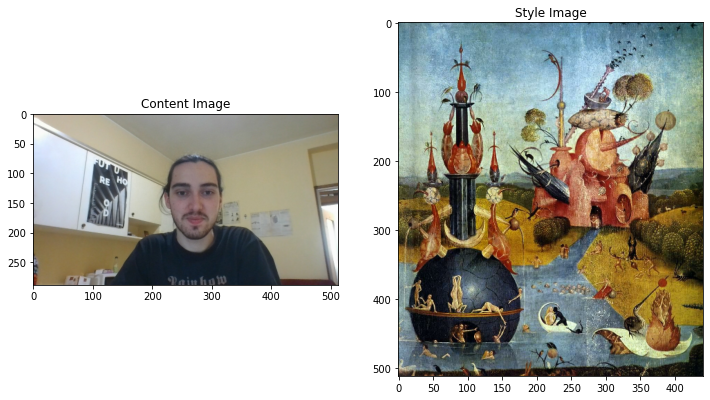

In [36]:
content_image = load_img(image_folder + content_filename)
style_image = load_img(image_folder + style_filename)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [37]:
# Load a VGG19 and test run it on our image to ensure it's used correctly:

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [ ]:
# Check Predictions for current image
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    # We want to use it as an extractor, so set to false train option
    vgg.trainable = False

    # FILL THE CODE: outputs must be a list containing tensor with the outputs 
    # of each layer contained in layer_names
    # HINT: from a functional model the outputs can be extracted using 
    # model.get_layer(name).output
    outputs = [vgg.get_layer(name).output for name in layer_names]


    # FILL THE CODE Build a functional model that gets vgg.input as input and  
    # outputs the content of each layer contained in layer_names
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()
    
# Model summary
style_extractor.summary()

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # Check
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)
    # this is the representation of style

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

    print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

In [ ]:
# Set your style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Define a tf.Variable to contain the image to optimize. To make this quick, initialize it with the content image 
image = tf.Variable(content_image)

# Clip the image
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

# To optimize this, use a weighted combination of the two losses to get the total loss:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# FILL THE CODE: here you will do a custom training loop as explained in the slide
# is a little bit different from the classic training loop since you will be operating
# directly on the image, not on the model, what you need to do is:
# -compute output
# -compute loss
# - compute gradient
# - apply gradient
# - clip the image: image.assign(clip_0_1(image))

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))   


In [ ]:

# FILL THE CODE: perform a few training steps
train_step(image)
train_step(image)
train_step(image)
train_step(image)


# Plot the image
tensor_to_image(image)

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [ ]:

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

# Custom
total_variation_loss_custom =total_variation_loss(image).numpy()
# Tensorflow
total_variation_loss =tf.image.total_variation(image).numpy()

print('Total variation loss (custom)',total_variation_loss_custom)
print('Total variation loss',total_variation_loss)

In [ ]:
# Choose a weight for the total_variation_loss
total_variation_weight=30

# FILL THE CODE: Include it in the train_step function
# Repeat the same custom training loop (tf.GradientTape...) that you did before
# only this take take into account the weighted total_variation loss and sum it
# to the loss

@tf.function()
def train_step(image):
   
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))   

In [ ]:
# Re-initialize the optimization variable:
image = tf.Variable(content_image)

# Run the optimization
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))